# 1.0. Connecting
## 1.1. Connect to Actian Vector using turbodbc
The [`turbodbc`](https://github.com/blue-yonder/turbodbc) library is a turbo-charged ODBC driver designed as a DBAPI2 compatible Python library. It can connect to any ODBC datasource. We will attempt to connect to the `ontimedb` database using it.

In [1]:
import turbodbc as odbc

# Connect to the imported data set
conn = odbc.connect('ontimedb')
# Create a cursor 
cursor = conn.cursor()
# Execute a sample query
cursor.execute('SELECT count(*) FROM ontime')
# Display the query result
print('Output:', cursor.fetchone())

Output: [165892051]


## 1.2. Connect to Actian Vector using pandas
Next up, we will verify that we can successfully connect to, and query the `ontimedb` database from `pandas` using the  `turbodbc` connection we established earlier. We will use the same query as above except this time, we will time how long it takes to complete.

In [2]:
%%time
import pandas as pd
s = ('SELECT count(*) FROM ontime')
q1 = pd.read_sql(s, conn)

CPU times: user 1.27 s, sys: 300 ms, total: 1.57 s
Wall time: 1.63 s


# 2.0. Querying
## 2.1. Sample Queries
Actian Vector published several [sample queries](http://docs.actian.com/vector/AWS/index.html#page/GetStart%2FMoreSampleQueries.htm%23) that can be used to explore the data set. In fact, the first query we ran is also the first query listed in that document. 

Below is the output of running that query. Notice that the number returned is identical to the number we obtained when we checked that the data set import was successful in the first part of this article.

In [3]:
q1

,col1
0,165892051


## 2.2. Helper Function
Let's add a helper function called `query()` that will allow us to run the remaining [sample queries](http://docs.actian.com/vector/AWS/index.html#page/GetStart%2FMoreSampleQueries.htm%23) inside our notebook using a single line of code.

In [4]:
def query(s):
    df = pd.read_sql(s, conn)
    return df

# 3.0. Visualizing
## 3.1. List of carriers

In [5]:
carriers = query('SELECT ccode as carrier, carrier as name from carriers')

In [6]:
carriers

,carrier,name
0,AS,Alaska Airlines (AS)
1,AA,American Airlines (AA)
2,DL,Delta Air Lines (DL)
3,EV,ExpressJet Airlines (EV)
4,F9,Frontier Airlines (F9)
5,HA,Hawaiian Airlines (HA)
6,B6,JetBlue Airways (B6)
7,OO,SkyWest Airlines (OO)
8,WN,Southwest Airlines (WN)
9,NK,Spirit Airlines (NK)


## 3.2. Number of flights per year

In [7]:
%%time
q2 = query('SELECT year, count(*) as frequency from ontime group by YEAR')

CPU times: user 36 ms, sys: 8 ms, total: 44 ms
Wall time: 1.61 s


In [8]:
q2.head()

,year,frequency
0,1987,1311826
1,1988,5202096
2,1989,5041200
3,1990,5270893
4,1991,5076925


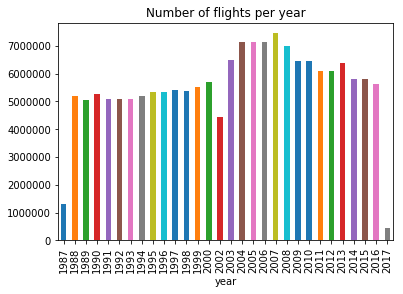

In [9]:
import matplotlib, seaborn
%matplotlib inline
q2.plot(kind='bar', x='year', y='frequency', title="Number of flights per year", legend=False)

## 3.3. Percentage of delays for each carrier for 2016 year

In [10]:
%%time
q3 = query('SELECT t.carrier, c, c2, c*100/c2 as c3 FROM (SELECT carrier, count(*) AS c FROM ontime WHERE DepDelay>10 AND Year=2016 GROUP BY carrier) t JOIN (SELECT carrier, count(*) AS c2 FROM ontime WHERE Year=2016 GROUP BY carrier) t2 ON (t.Carrier=t2.Carrier) ORDER BY c3 DESC')

CPU times: user 32 ms, sys: 52 ms, total: 84 ms
Wall time: 1 s


In [11]:
q3.head()

,carrier,c,c2,c3
0,B6,76205,282473,26
1,NK,35605,138199,25
2,F9,22938,95121,24
3,VX,16904,69121,24
4,WN,298848,1299444,22


The carrier codes are a bit cryptic, so unless it is your job to stare at airline codes all day, we need a way to display a human-friendly formatting of the airline carriers.
We will achieve this by performing a lazy man's join using `pandas.merge()` to join the result (`q3`) with our in-memory copy of the `carriers` table, which we loaded earlier for query Q1.0. 

In [12]:
q3 = pd.merge(q3, carriers, on='carrier')
q3

,carrier,c,c2,c3,name
0,B6,76205,282473,26,JetBlue Airways (B6)
1,NK,35605,138199,25,Spirit Airlines (NK)
2,F9,22938,95121,24,Frontier Airlines (F9)
3,VX,16904,69121,24,Virgin America (VX)
4,WN,298848,1299444,22,Southwest Airlines (WN)
5,UA,118056,545067,21,United Airlines (UA)
6,AA,177497,914495,19,American Airlines (AA)
7,EV,90510,490990,18,ExpressJet Airlines (EV)
8,DL,151922,922746,16,Delta Air Lines (DL)
9,OO,99356,605933,16,SkyWest Airlines (OO)


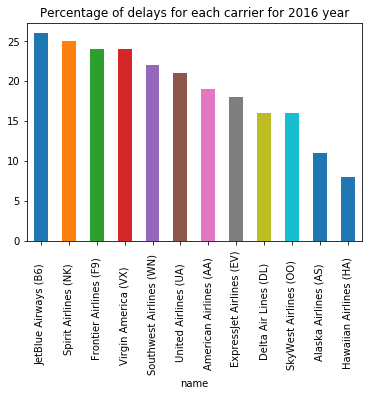

In [13]:
q3.plot(kind='bar', x='name', y='c3', title="Percentage of delays for each carrier for 2016 year", legend=False)

## 3.16. Running total of flights over the years by carrier
This is the last query from that sample. It's a fairly expensive query (taking ~10s on average) as it involves performing a scan of nearly all the records in the `ontime` table.

In [14]:
%%time
q16 = query('WITH t AS (SELECT carrier, year, count(*) cnt FROM ontime GROUP BY carrier, year) SELECT carrier, year, cnt, sum(cnt) OVER (PARTITION BY carrier ORDER BY carrier, year ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS "running_total" FROM t')
# I removed the 'FETCH FIRST 10 ROWS ONLY' filter so it fetches everything :)

CPU times: user 12 ms, sys: 40 ms, total: 52 ms
Wall time: 11.4 s


In [15]:
q16 = pd.merge(q16, carriers, on='carrier')
q16.head()

,carrier,year,cnt,running_total,name
0,AA,1987,165121,165121,American Airlines (AA)
1,AA,1988,694757,859878,American Airlines (AA)
2,AA,1989,723252,1583130,American Airlines (AA)
3,AA,1990,712060,2295190,American Airlines (AA)
4,AA,1991,725191,3020381,American Airlines (AA)


Now let's create a function that will iterate over each carrier, then plot the flights per year as well as the cummulative flights.

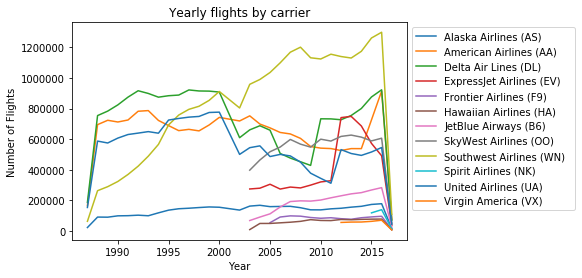

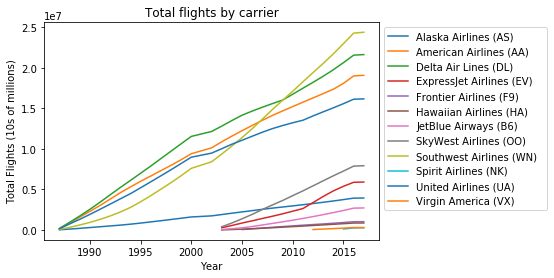

In [16]:
def plot_df_array(df_array, y, ylabel, title):    
    node_first = True
    axis = None
    for df in df_array:
        if df.shape[0] == 0:
            continue
        
        if node_first == True:
            node_first = False
            axis = df.plot(kind='line', x='year', y=y, label=df.name.unique()[0], title=title)                   
        else:
            df.plot(kind='line', x='year', y=y, ax=axis, label=df.name.unique()[0])    
    axis.set_xlabel('Year')
    axis.set_ylabel(ylabel) 
    axis.legend(loc='best', bbox_to_anchor=(1, 1))
    
dfs = [q16[q16.carrier == carrier] for carrier in carriers['carrier']]
plot_df_array(dfs, y='cnt', ylabel='Number of Flights', title='Yearly flights by carrier')    
plot_df_array(dfs, y='running_total', ylabel='Total Flights (10s of millions)', title='Total flights by carrier')    


# 4.0. Conclusion
There are very limited visualization tools for connecting to an Actian Vector database running on Linux; most of the tools that could connect over ODBC only supported Windows. 

I had planned to use Apache Superset but its ODBC + ORM combo for connecting to a variety of database failed to work. The ORM library -- SqlAlchemy -- kept using the Microsoft SQL Server dialect whenever it tried to query the database metadata, which of course lead to syntax errors like this one for example: 
```
  [Actian][Ingres ODBC Driver][Ingres]Syntax error.  Last symbol read was: 'slc'. (2076) (SQLExecDirectW)\") (Background on this error at: http://sqlalche.me/e/f405)
```

As a workaround, I decided to use this Jupyter Notebook to code the visualizations by hand.

Some parts of this guide was inspired by the very well written instructions that were provided in this Jupyter [notebook](https://github.com/cjalmeida/vector_tutorial/blob/master/ActianVector.ipynb) hosted on GitHub, describing how to interact with an Actian Vector database running on Linux using ODBC.